###Please make sure that your notebook is running on GPU since we will be handeling some pretty hefty algoritms. You can change the notebook setting via Edit>Notebook settings>Hardware accelerator>GPU

In [ ]:
!pip install pandas_profiling==2.9.0 -U -q

In [ ]:
# Import needed packages
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models, Sequential, layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import optimizers
from numpy import load

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Pittfalls and Biases Part 1

In this notebook we will go over some of the most common pittfalls and biases in machine learning. To do this we will make use of the COVID-19 Radiography Database from kaggle: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database 

The goal of this lecture is to make you aware of the potential risks that hide in working with big data. And escpecially open source data. 

First of all let's start this session by taking a good look at the data set. Open the link and see if you can find any notable things. 

Maybe you already found some interesting things. Maybe not, let's take a closer look at the individual images. 

In [ ]:
#https://drive.google.com/file/d/1fdB5DdBwSTmSkWoqoqigIOuNm-p4Rl1H/view?usp=sharing 
!gdown --id 1fdB5DdBwSTmSkWoqoqigIOuNm-p4Rl1H

#https://drive.google.com/file/d/1--C_3EustzWG-4AMe9gz8-15GksYZanJ/view?usp=sharing
!gdown --id 1--C_3EustzWG-4AMe9gz8-15GksYZanJ

Downloading...
From: https://drive.google.com/uc?id=1fdB5DdBwSTmSkWoqoqigIOuNm-p4Rl1H
To: /content/train_dataset.npz
100% 236M/236M [00:02<00:00, 82.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--C_3EustzWG-4AMe9gz8-15GksYZanJ
To: /content/test_dataset.npz
100% 47.1M/47.1M [00:01<00:00, 30.0MB/s]


In [ ]:
train = load('/content/train_dataset.npz')
test = load('/content/test_dataset.npz')

x_train, y_train = train['arr_0'], train['arr_1']
x_test, y_test = test['arr_0'], test['arr_1']

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4000, 256, 256, 3), (4000,), (800, 256, 256, 3), (800,))

1


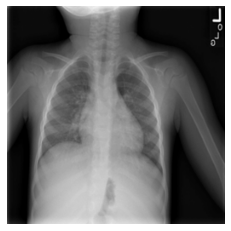

In [ ]:
from matplotlib import pyplot

idx = 1002   # Change this number to see other images
pyplot.axis('off')
pyplot.imshow(x_train[idx], cmap='gray')
print(y_train[idx])

# 0 = viral pneumonia (images train: 0-999      test: 0-199)
# 1 = normal          (images train: 1000-1999  test: 200-399)
# 2 = lung opacity    (images train: 2000-2999  test: 400-599)
# 3 = covid           (images train: 3000-3999  test: 600-799)

##Excersize 1
A) Define what is the signal and what is the noise in this dataset.

B) Name 3 types of noise that you found in the images.

C) By looking at the images, can you predict if a Convolutional Neural Network will overfit? And what do you need to look at to predict this.

D) What can you say about train/test leakage in this dataset?

## Let's put this to the test

In the next part we will use transfer learning to train a ResNet50 on our data. For now it is not important to fully understand what a ResNet is. It basicly is a very large CNN, trained on millions of images. This ensures that the network is already able to recognize certain patterns. In the next bootcamp lecture we will dive deeper into the world of transfer learning.  

Run the following cells to train your ResNet, and evaluate it on the test set. (This may take 3-5 minutes, so grab yourself a nice coffee or a snack ;)

In [ ]:
#Loading the ResNet-50 model, removing the toplayers and keeping the rest of the pre-trained layers frozen.

res = ResNet50(include_top=False, weights='imagenet' ,input_shape=(256, 256, 3))

for layer in res.layers:
  layer.trainable = False

x = Flatten()(res.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
pred = Dense(4, activation='softmax')(x)

model = keras.Model(res.input, pred)


# summarize the model
#model.summary()

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Compile model 
adam = optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
# train model
with tf.device('/device:GPU:0'):  
  model.fit(
    x = x_train,
    y = y_train,
    batch_size = 20,
    validation_split = 0.1,
    epochs = 10,
    verbose = 1)

Epoch 1/10
180/180 [==============================] - 77s 246ms/step - loss: 5.2375 - accuracy: 0.7378 - val_loss: 0.2487 - val_accuracy: 0.9000
Epoch 2/10
180/180 [==============================] - 42s 232ms/step - loss: 0.5889 - accuracy: 0.8483 - val_loss: 0.7780 - val_accuracy: 0.6675
Epoch 3/10
180/180 [==============================] - 42s 231ms/step - loss: 0.4732 - accuracy: 0.8664 - val_loss: 0.6055 - val_accuracy: 0.7950
Epoch 4/10
180/180 [==============================] - 43s 238ms/step - loss: 0.3512 - accuracy: 0.8897 - val_loss: 0.3660 - val_accuracy: 0.8725
Epoch 5/10
180/180 [==============================] - 43s 238ms/step - loss: 0.2444 - accuracy: 0.9206 - val_loss: 0.3508 - val_accuracy: 0.8575
Epoch 6/10
180/180 [==============================] - 43s 239ms/step - loss: 0.2624 - accuracy: 0.9194 - val_loss: 0.7273 - val_accuracy: 0.7800
Epoch 7/10
180/180 [==============================] - 43s 238ms/step - loss: 0.2166 - accuracy: 0.9300 - val_loss: 1.0607 - val_ac

In [ ]:
model.evaluate(x_test,y_test)

25/25 [==============================] - 9s 259ms/step - loss: 0.2985 - accuracy: 0.9038


[0.2985245883464813, 0.9037500023841858]

In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(x_test)
pred = pred.argmax(axis=1)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       200
           1       0.87      0.83      0.85       200
           2       0.84      0.89      0.86       200
           3       0.94      0.91      0.92       200

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



## Excersize 2 

A) Do you recognize any signs of overfitting in the accuracy values?

B) What does the test accuracy indicate about overfitting?

C) Try to change some parameters, add/remove layers and see how this effects the accuracy values.

D) Try to look up how accurate trained radiologists are able to classify COVID-19 patients. And compare this to the outcome of our model.

E) Do you notice anything remarkable?

## Excersize 3

A) Discuss with your group what steps you could take to improve the robustness of this model and prevent it from overfitting.

B) Write out a plan on how to improve this model:

Consider the following:

- Data collection
- Pre-processing steps
- Changes of the model 

## Excersize 4

For the next excersize you will have to train your own model. We will use the same dataset but this time we will do binary classification between normal lungs and COVID-19 infected lungs.

A) Create new arrays for x_train, y_train, x_test and y_test so that you only have the 'normal' and 'covid' cases.

B) Train a binary classification model on your new dataset. (You may choose to use the ResNet50 model or any other transferlearning model.) You may also try to build a CNN from scratch.

C) Evalute the results with your group. Discuss if there are any signs of overfitting and what can possibly cause this.

In [ ]:
# Solutions
import numpy as np
from sklearn.preprocessing import label_binarize

new_x_train = np.append(x_train[1000:2000], x_train[3000:4000], axis=0)
new_y_train = np.append(y_train[1000:2000], y_train[3000:4000], axis=0)
new_x_test = np.append(x_test[200:400], x_test[600:800], axis=0)
new_y_test = np.append(y_test[200:400], y_test[600:800], axis=0)

new_y_train = label_binarize(new_y_train, classes=[0,1])
new_y_test = label_binarize(new_y_test, classes=[0,1])

print('train:',new_x_train.shape, new_y_train.shape,'test:', new_x_test.shape, new_y_test.shape)

train: (2000, 256, 256, 3) (2000, 1) test: (400, 256, 256, 3) (400, 1)


In [ ]:
#Loading a new ResNet-50 model, removing the toplayers and keeping the rest of the pre-trained layers frozen.

new_res = ResNet50(include_top=False, weights='imagenet' ,input_shape=(256, 256, 3))

for layer in new_res.layers:
  layer.trainable = False

x = Flatten()(new_res.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
pred = Dense(1, activation='sigmoid')(x)

new_model = keras.Model(new_res.input, pred)


# summarize the model
#new_model.summary()

In [ ]:
# Compile model 
adam = optimizers.Adam()
new_model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
# train model
with tf.device('/device:GPU:0'):  
  new_model.fit(
    x = new_x_train,
    y = new_y_train,
    batch_size = 20,
    validation_split = 0.1,
    epochs = 10,
    verbose = 1)

Epoch 1/10
90/90 [==============================] - 25s 246ms/step - loss: 4.1521 - accuracy: 0.8222 - val_loss: 0.3022 - val_accuracy: 0.9600
Epoch 2/10
90/90 [==============================] - 22s 239ms/step - loss: 0.8348 - accuracy: 0.9183 - val_loss: 0.9638 - val_accuracy: 0.8950
Epoch 3/10
90/90 [==============================] - 21s 231ms/step - loss: 0.4483 - accuracy: 0.9539 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 4/10
90/90 [==============================] - 21s 238ms/step - loss: 0.2494 - accuracy: 0.9594 - val_loss: 0.2449 - val_accuracy: 0.9500
Epoch 5/10
90/90 [==============================] - 21s 231ms/step - loss: 0.1479 - accuracy: 0.9728 - val_loss: 0.0849 - val_accuracy: 0.9800
Epoch 6/10
90/90 [==============================] - 21s 238ms/step - loss: 0.1387 - accuracy: 0.9761 - val_loss: 0.3659 - val_accuracy: 0.9400
Epoch 7/10
90/90 [==============================] - 21s 238ms/step - loss: 0.0996 - accuracy: 0.9856 - val_loss: 0.1416 - val_accuracy: 0.9650

In [ ]:
new_model.evaluate(new_x_test,new_y_test)

13/13 [==============================] - 6s 329ms/step - loss: 0.3469 - accuracy: 0.9625


[0.3469383716583252, 0.9624999761581421]

# Part 2

In this second part of the notebook we will dive deeper into biases and how to avoid them. To show this we use the propublica database containing the criminal history, jail and prison time, demographics and COMPAS risk scores for defendants from Broward County from 2013 and 2014. https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis 

First load in the dataset and have a look at all the variables. For more information about the dataset see the methodology of the COMPAS Recidivism Algorithm https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm 

In [ ]:
!git clone https://github.com/propublica/compas-analysis.git

Cloning into 'compas-analysis'...
remote: Enumerating objects: 31, done.
remote: Total 31 (delta 0), reused 0 (delta 0), pack-reused 31
Unpacking objects: 100% (31/31), done.


In [ ]:
import pandas as pd
df = pd.read_csv('compas-analysis/compas-scores-two-years.csv')
#df = pd.read_csv('/usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(df, explorative=True)

Summarize dataset:   0%|          | 0/62 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

### Exercise 1 Exploring

A) First, replace the categories "Asian" & "Native American" with "Other" to make plots easier to read. 

B) Use sns.countplot() and "score_text" to create 3 plots with the following information:
  - COMPAS score per race
  - COMPAS score per age_cat
  - COMPAS score per gender

C) Use sns.barplot() and "two_year_recid" to create bar plots with the probabilities of:
  - Recidivism per race
  - Recidivism per age_cat
  - Recidivism per gender

In [ ]:
df.race = df.race.replace({"Asian":"Other", "Native American": "Other"})
# df = df[df.race != 'Other']
# df = df[df.race != 'Native American']
# df = df[df.race != 'Hispanic']
# df = df[df.race != 'Asian']

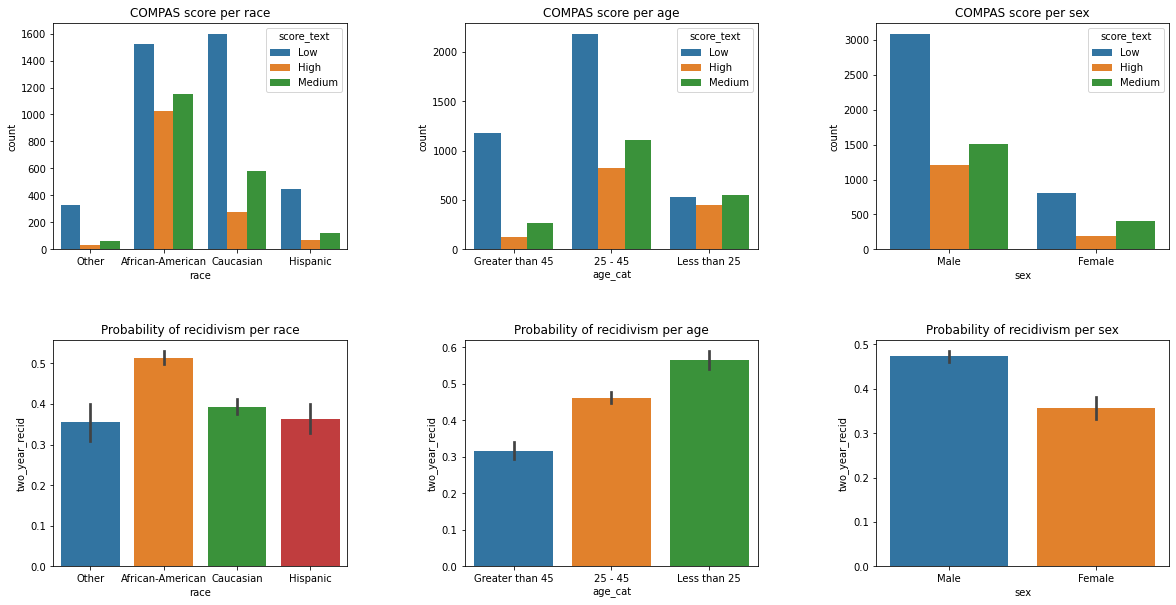

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(2, 3, 1)
sns.countplot(x = "race", hue='score_text', data = df )
plt.title('COMPAS score per race')
plt.ylabel('count')

plt.subplot(2, 3, 2)
sns.countplot(x = "age_cat", hue='score_text', data = df )
plt.title("COMPAS score per age")

plt.subplot(2, 3, 3)
sns.countplot(x = "sex", hue='score_text', data = df )
plt.title("COMPAS score per sex")

plt.subplot(2, 3, 4)
sns.barplot(x = "race", y='two_year_recid', data = df)
plt.title('Probability of recidivism per race')

plt.subplot(2, 3, 5)
sns.barplot(x = "age_cat", y='two_year_recid', data = df)
plt.title("Probability of recidivism per age")

plt.subplot(2, 3, 6)
sns.barplot(x = "sex", y='two_year_recid', data = df)
plt.title("Probability of recidivism per sex")

plt.show()

### Exercise 2

"To test racial disparities in the score controlling for other factors, we created a logistic regression model that considered race, age, criminal history, future recidivism, charge degree and gender"

A) Create a dataframe with the features:
  - sex
  - c_charge_degree
  - decile_score
  - age
  - prior_count

B) Create a target variable from two_year_recid.

C) Fit a logistic regression model with x = features from 2A, y = target from 2B

D) Create a Classification report

In [ ]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

df_new = df.copy()

df_new.sex = enc.fit_transform(df_new.sex)
df_new.c_charge_degree = enc.fit_transform(df_new.c_charge_degree)

features = pd.concat([df_new.sex, 
                       df_new.c_charge_degree, 
                       df_new.age,
                      df_new.decile_score, 
                       df_new.priors_count], 
                      axis=1)

In [ ]:
features

,sex,c_charge_degree,age,decile_score,priors_count
0,1,0,69,1,0
1,1,0,34,3,0
2,1,0,24,4,4
3,1,0,23,8,1
4,1,0,43,1,2
...,...,...,...,...,...
7209,1,0,23,7,0
7210,1,0,23,3,0
7211,1,0,57,1,0
7212,0,1,33,2,3


In [ ]:
#df.score_text = df.score_text.replace({'Low': 0, 'Medium': 1, 'High': 2})
target = df.two_year_recid

In [ ]:
from sklearn.linear_model import LogisticRegression

x = features.values
y = target.values
lr = LogisticRegression()
lr.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
from sklearn.metrics import classification_report
y_pred = lr.predict(x)

print(classification_report(y_pred,df.two_year_recid))

              precision    recall  f1-score   support

           0       0.77      0.68      0.73      4482
           1       0.56      0.67      0.61      2732

    accuracy                           0.68      7214
   macro avg       0.67      0.68      0.67      7214
weighted avg       0.69      0.68      0.68      7214



### Exersize 3

A) Create a subset of for race == 'Caucasian' and race == 'African-American'

B) Use sklearns classification report to analyse the differences between the subsets

C) Try to find out what causes the bias. Experiment with feature selection and models used.

In [ ]:

from sklearn.metrics import classification_report

print('Caucasian')
subset = df.race == 'Caucasian'
print(classification_report(target[subset], y_pred[subset]))

print('African-American')
subset = df.race == 'African-American'
print(classification_report(target[subset], y_pred[subset]))

Caucasian
              precision    recall  f1-score   support

           0       0.70      0.86      0.77      1488
           1       0.67      0.43      0.52       966

    accuracy                           0.69      2454
   macro avg       0.68      0.64      0.65      2454
weighted avg       0.69      0.69      0.67      2454

African-American
              precision    recall  f1-score   support

           0       0.66      0.67      0.66      1795
           1       0.68      0.67      0.67      1901

    accuracy                           0.67      3696
   macro avg       0.67      0.67      0.67      3696
weighted avg       0.67      0.67      0.67      3696



### Now we will use the AIF360 library to add weights to our dataset and mitigate bias.

In [ ]:
# Install the AIF 360 library
!pip install aif360 -q
!pip install fairlearn -q
!pip install lime -q

     |████████████████████████████████| 175 kB 5.3 MB/s 
     |████████████████████████████████| 371 kB 39.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 177 kB 5.3 MB/s 
     |████████████████████████████████| 275 kB 5.4 MB/s 


In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.model_selection import train_test_split
from aif360.datasets import CompasDataset
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset

### Exersice 4

A) Create a dataframe that includes the features form exercise 2 + the target column and the column for Race.

B) Use the AIF360 library to create a BinaryLabelDataset and call it train_BLD

C) Use the code given below to calculate the group difference in means. 

In [ ]:
features['recid'] = pd.concat([df.two_year_recid], axis=1)
features['race'] = pd.concat([df.race], axis=1)
features.race = pd.get_dummies(features.race)
features = features.dropna()
features

,sex,c_charge_degree,age,decile_score,priors_count,recid,race
0,1,0,69,1,0,0,0
1,1,0,34,3,0,1,1
2,1,0,24,4,4,1,1
3,1,0,23,8,1,0,1
4,1,0,43,1,2,0,0
...,...,...,...,...,...,...,...
7209,1,0,23,7,0,0,1
7210,1,0,23,3,0,0,1
7211,1,0,57,1,0,0,0
7212,0,1,33,2,3,0,1


In [ ]:
x = features.drop(columns=['recid']).values
y = features['recid'].values

In [ ]:
train_BLD = BinaryLabelDataset(favorable_label='0',
                                unfavorable_label='1',
                                df=features,
                                label_names=['recid'],
                                protected_attribute_names=['race'],
                                unprivileged_protected_attributes=['1']
                                )

In [ ]:
print(train_BLD)

               instance weights features  ...                     labels
                                          ... protected attribute       
                                     sex  ...                race       
instance names                            ...                           
0                           1.0      1.0  ...                 0.0    0.0
1                           1.0      1.0  ...                 1.0    1.0
2                           1.0      1.0  ...                 1.0    1.0
3                           1.0      1.0  ...                 1.0    0.0
4                           1.0      1.0  ...                 0.0    0.0
...                         ...      ...  ...                 ...    ...
7209                        1.0      1.0  ...                 1.0    0.0
7210                        1.0      1.0  ...                 1.0    0.0
7211                        1.0      1.0  ...                 0.0    0.0
7212                        1.0      0.0  ...      

In [ ]:
from IPython.display import Markdown, display
privileged_groups = [{'race': 0}]
unprivileged_groups = [{'race': 1}]

metric_orig_train = BinaryLabelDatasetMetric(train_BLD, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

### Now we know our data is indeed biased. In order to fix this we will need to reweigh the data. 

### Exercise 5

A) Look up Reweighing in the AIF360 library and use it on your train_BLD dateframe

B) Run the code given at exercise 4 to check if the reweighing fixed the mean difference between groups. 

In [ ]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
rw_train_BLD = RW.fit_transform(train_BLD)

In [ ]:
metric_transf_train = BinaryLabelDatasetMetric(rw_train_BLD, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [ ]:
print(rw_train_BLD)

               instance weights features  ...                     labels
                                          ... protected attribute       
                                     sex  ...                race       
instance names                            ...                           
0                      0.891424      1.0  ...                 0.0    0.0
1                      0.876175      1.0  ...                 1.0    1.0
2                      0.876175      1.0  ...                 1.0    1.0
3                      1.131138      1.0  ...                 1.0    0.0
4                      0.891424      1.0  ...                 0.0    0.0
...                         ...      ...  ...                 ...    ...
7209                   1.131138      1.0  ...                 1.0    0.0
7210                   1.131138      1.0  ...                 1.0    0.0
7211                   0.891424      1.0  ...                 0.0    0.0
7212                   1.131138      0.0  ...      

### Exercise 6

A) Train a new logistig regression model on your dataframe but now use sample_weight to specify the weights created during reweighing.

B) Run a classification report for your new logistic regression model and compare the results to the ones you got from exercise 3.

In [ ]:
new_lr = lr.fit(x, y, sample_weight=rw_train_BLD.instance_weights)

rw_y_pred = new_lr.predict(x)

In [ ]:
print('Caucasian')
subset = df.race == 'Caucasian'
print(classification_report(target[subset], rw_y_pred[subset]))

print('African-American')
subset = df.race == 'African-American'
print(classification_report(target[subset], rw_y_pred[subset]))

Caucasian
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1488
           1       0.61      0.56      0.58       966

    accuracy                           0.68      2454
   macro avg       0.67      0.66      0.66      2454
weighted avg       0.68      0.68      0.68      2454

African-American
              precision    recall  f1-score   support

           0       0.63      0.77      0.69      1795
           1       0.72      0.56      0.63      1901

    accuracy                           0.66      3696
   macro avg       0.67      0.67      0.66      3696
weighted avg       0.68      0.66      0.66      3696



In [ ]:
print('Caucasian')
subset = df.race == 'Caucasian'
print(classification_report(target[subset], y_pred[subset]))

print('African-American')
subset = df.race == 'African-American'
print(classification_report(target[subset], y_pred[subset]))

Caucasian
              precision    recall  f1-score   support

           0       0.70      0.86      0.77      1488
           1       0.67      0.43      0.52       966

    accuracy                           0.69      2454
   macro avg       0.68      0.64      0.65      2454
weighted avg       0.69      0.69      0.67      2454

African-American
              precision    recall  f1-score   support

           0       0.66      0.67      0.66      1795
           1       0.68      0.67      0.67      1901

    accuracy                           0.67      3696
   macro avg       0.67      0.67      0.67      3696
weighted avg       0.67      0.67      0.67      3696



### If everything went right you should be able to see the impact that reweiging had on your data. For further exploration of reweiging you can check out this tutorial https://nbviewer.org/github/Trusted-AI/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb 



In [ ]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

In [ ]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:        
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset)
        
        pos_ind = 0
   
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:,pos_ind] > thresh).astype(np.float64)
       
        dataset_pred = dataset.copy()

        dataset_pred.labels = y_val_pred

        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
        
        
        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [ ]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=rw_train_BLD,
                   model=new_lr,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

invalid value encountered in double_scalars


In [ ]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

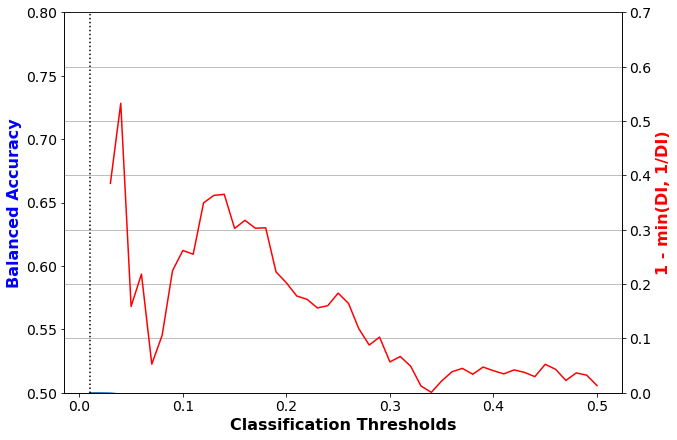

In [ ]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

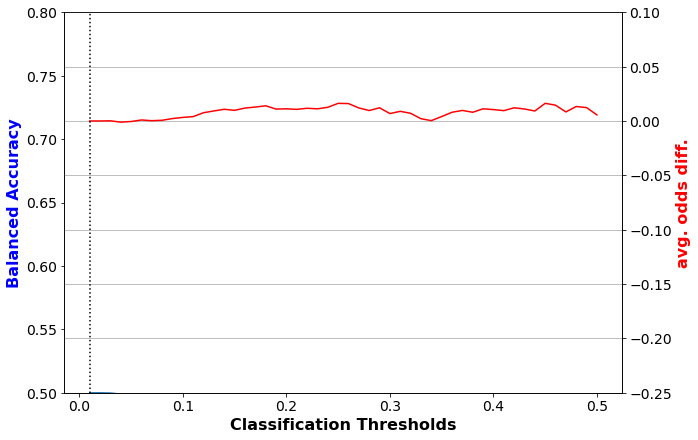

In [ ]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')